In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import open_clip
from torchvision import datasets, transforms
import torch
from PIL import Image
import open_clip
from tqdm import tqdm
from torch.utils.data import DataLoader
import numpy as np
from sklearn import calibration
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch.nn as nn
import torch.optim as optim
from sklearn.tree import DecisionTreeRegressor as DT
from sklearn.isotonic import IsotonicRegression as IR
from scipy.stats import norm
from tqdm import tqdm
import pandas as pd

/home/ubuntu/anaconda3/envs/content_understanding/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
from util import get_preds, calc_bins, get_metrics, T_scaling, find_temp_scale, get_test_set, get_openai_prompts, get_val_set, find_temp_scale_with_q, get_text_probs, sample_quantile

In [3]:
device = torch.device('cuda:4' if torch.cuda.is_available() else 'cpu')
batch_size = 128

In [64]:
model_name = 'ViT-B-16'#'ViT-B-32-quickgelu'
dataset_name = 'CIFAR100'
num_classes = 100

model, _, preprocess = open_clip.create_model_and_transforms(model_name,
    pretrained='laion400m_e31',
    device=device)
tokenizer = open_clip.get_tokenizer(model_name)

In [65]:
cifar_test, _ = get_test_set(dataset_name, preprocess)
classes, templates = get_openai_prompts(dataset_name)
val_dset = get_val_set(dataset_name, classes, preprocess)

Files already downloaded and verified
Files already downloaded and verified


In [66]:
text_template = templates[1]
text_probs = get_text_probs(
        model=model,
        tokenizer=tokenizer,
        dset=val_dset,
        text_template=text_template,
        batch_size=batch_size,
        device=device
    )

In [67]:
## Get threshold
text_probs_numpy = text_probs.softmax(dim=-1).cpu().numpy()

## Setup LBGFS
temperature = nn.Parameter((torch.ones(1)).to(device))
args = {'temperature': temperature}
criterion = nn.CrossEntropyLoss()

# Removing strong_wolfe line search results in jump after 50 epochs
optimizer = optim.LBFGS([temperature], lr=0.001, max_iter=1000, line_search_fn='strong_wolfe')

logits_list = []
labels_list = []

predicted_label = text_probs_numpy.argmax(axis=1)

added = np.zeros(len(text_probs_numpy[0]))
for k in range(len(text_probs_numpy[0])):
    # set where predicted_label is not k
    logits_u = text_probs_numpy[predicted_label != k,:]

    mean_softmax_yk = logits_u[:,k].mean()
    std_softmax_yk = logits_u[:,k].std()

    thresh = mean_softmax_yk + std_softmax_yk
    print(thresh)
    for j in np.where(text_probs_numpy[:,k] >= thresh)[0]:
        added[k] += 1
        logits_list.append(text_probs[j].unsqueeze(0))
        labels_list.append(k)

logits_list = torch.cat(logits_list).to(device) # [len(dset), 100]
labels_list = torch.FloatTensor(labels_list).to(device).long()

temps = []
losses = []
def _eval():
    loss = criterion(T_scaling(logits_list, args), labels_list)
    loss.backward()
    temps.append(temperature.item())
    losses.append(loss)
    return loss

optimizer.step(_eval)

0.00984
0.01651
0.01839
0.01715
0.02884
0.01207
0.01138
0.02626
0.007423
0.01724
0.01912
0.02338
0.013466
0.01685
0.01122
0.0197
0.00999
0.00981
0.03102
0.014984
0.01761
0.01268
0.01358
0.01718
0.02376
0.01206
0.01604
0.01279
0.01489
0.015144
0.0279
0.014595
0.02986
0.012825
0.02206
0.02576
0.0231
0.00901
0.01929
0.01047
0.015175
0.02188
0.01075
0.0202
0.02473
0.012436
0.014946
0.02292
0.006454
0.01226
0.02892
0.02234
0.0236
0.01191
0.01344
0.02545
0.0107
0.01523
0.01292
0.02264
0.04407
0.01787
0.01987
0.0158
0.02559
0.01886
0.01694
0.02893
0.01297
0.02304
0.012146
0.01363
0.02815
0.0232
0.02649
0.0187
0.012634
0.02397
0.02757
0.01412
0.02176
0.01668
0.00887
0.01052
0.01348
0.01063
0.011635
0.01683
0.014984
0.01534
0.012024
0.02261
0.0209
0.01215
0.01205
0.03247
0.02922
0.01663
0.01883
0.03302


tensor(1.7394, device='cuda:4', grad_fn=<NllLossBackward0>)

(array([9.083e+03, 2.300e+02, 8.900e+01, 6.600e+01, 4.000e+01, 3.100e+01,
        3.200e+01, 1.100e+01, 2.400e+01, 1.600e+01, 1.300e+01, 7.000e+00,
        1.100e+01, 1.000e+01, 1.000e+01, 5.000e+00, 9.000e+00, 8.000e+00,
        7.000e+00, 2.000e+00, 6.000e+00, 8.000e+00, 9.000e+00, 6.000e+00,
        8.000e+00, 2.000e+00, 4.000e+00, 9.000e+00, 5.000e+00, 1.000e+00,
        5.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 3.000e+00, 5.000e+00,
        2.000e+00, 2.000e+00, 4.000e+00, 1.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        3.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 1.000e+00,
        2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 3.000e+0

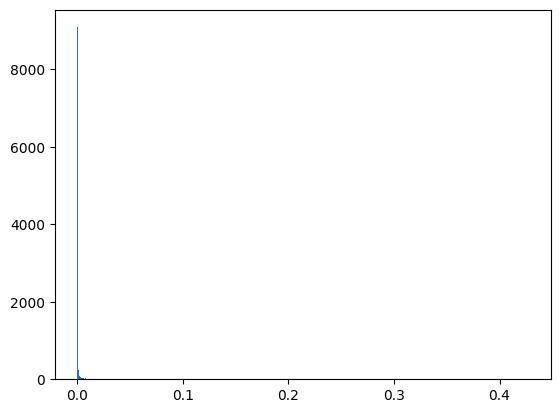

In [69]:
plt.hist(text_probs_numpy[np.where(text_probs_numpy.argmax(axis=1) != 3)[0],3], bins=500)
#plt.ylim([0,500])

In [70]:
added

array([163., 235., 255., 296., 456., 153., 218., 311., 139., 212., 237.,
       276., 140., 190., 179., 320., 156., 146., 469., 221., 294., 241.,
       248., 256., 325., 136., 172., 199., 227., 278., 287., 211., 365.,
       135., 338., 246., 340., 111., 316., 164., 192., 407., 119., 243.,
       391., 159., 179., 281., 129., 169., 387., 318., 267., 205., 181.,
       337., 258., 235., 173., 279., 708., 240., 233., 245., 342., 236.,
       287., 418., 153., 384., 141., 142., 439., 322., 420., 313., 182.,
       421., 324., 230., 336., 185., 151., 164., 200., 213., 174., 282.,
       212., 226., 141., 276., 272., 183., 178., 358., 360., 191., 212.,
       552.])

In [63]:
text_probs[0]

tensor([ 9.2812,  9.5547, 10.1641,  7.3984,  7.2734,  7.1094,  8.9766,  7.3164,
        19.5938,  8.5703], device='cuda:4', dtype=torch.float16)